In [1]:
import pandas as pd

# Load all three CSV files
file_paths = [
    "/content/gsw-shg-en 2022-2023.csv",
    "/content/gsw-shg-en 2023-2024.csv",
    "/content/gsw-shg-en 2024-2025.csv"
]

# Read and concatenate all datasets, handling errors and potential delimiters
df_all = pd.concat([
    pd.read_csv(
        file,
        encoding='latin-1',
        on_bad_lines='skip',  # Skip lines with errors
        sep=',',             # Explicitly define the delimiter as a comma
        #engine='python'       # Consider using the Python engine if 'c' fails
    )
    for file in file_paths
], ignore_index=True)

# Display basic info to understand structure
df_all.info(), df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516889 entries, 0 to 516888
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   grain_week        516889 non-null  int64 
 1   crop_year         516889 non-null  object
 2   week_ending_date  516889 non-null  object
 3   worksheet         516889 non-null  object
 4   metric            516889 non-null  object
 5   period            516889 non-null  object
 6   grain             516889 non-null  object
 7   grade             152100 non-null  object
 8   region            503473 non-null  object
 9   Ktonnes           516887 non-null  object
dtypes: int64(1), object(9)
memory usage: 39.4+ MB


(None,
    grain_week  crop_year week_ending_date    worksheet      metric  \
 0           1  2022-2023       07/08/2022  Feed Grains  Deliveries   
 1           1  2022-2023       07/08/2022  Feed Grains  Deliveries   
 2           1  2022-2023       07/08/2022  Feed Grains  Deliveries   
 3           1  2022-2023       07/08/2022  Feed Grains  Deliveries   
 4           1  2022-2023       07/08/2022  Feed Grains  Deliveries   
 
          period  grain grade            region Ktonnes  
 0  Current Week  Wheat   NaN          Manitoba     0.7  
 1  Current Week  Wheat   NaN      Saskatchewan     1.2  
 2  Current Week  Wheat   NaN           Alberta     1.3  
 3  Current Week  Wheat   NaN  British Columbia     0.1  
 4  Current Week   Oats   NaN          Manitoba       0  )

Step 1: Filter the Data

In [2]:
# Fix: Convert Ktonnes to string, remove commas, convert to float
df_all["Ktonnes"] = pd.to_numeric(df_all["Ktonnes"].astype(str).str.replace(",", ""), errors="coerce")

# Filter for Terminal Exports, Corn and Soybeans, Bay & Lakes and St. Lawrence
filtered_df = df_all[
    (df_all["worksheet"] == "Terminal Exports") &
    (df_all["grain"].isin(["Corn", "Soybeans"])) &
    (df_all["region"].isin(["Bay & Lakes", "St. Lawrence"]))
]

# Convert week_ending_date to datetime format
filtered_df = filtered_df.copy()
filtered_df["week_ending_date"] = pd.to_datetime(filtered_df["week_ending_date"], dayfirst=True, errors="coerce")

# Group by week and grain
weekly_exports = filtered_df.groupby(["week_ending_date", "grain"])["Ktonnes"].sum().reset_index()

# Pivot so Corn and Soybeans are separate columns
pivot_df = weekly_exports.pivot(index="week_ending_date", columns="grain", values="Ktonnes")
pivot_df = pivot_df.sort_index()

pivot_df.head()


grain,Corn,Soybeans
week_ending_date,,
2022-08-07,46.6,34.2
2022-08-14,42.7,24.5
2022-08-21,58.2,20.8
2022-08-28,110.2,21.2
2022-09-04,98.9,21.0


Visualize the time series (Corn & Soybeans)

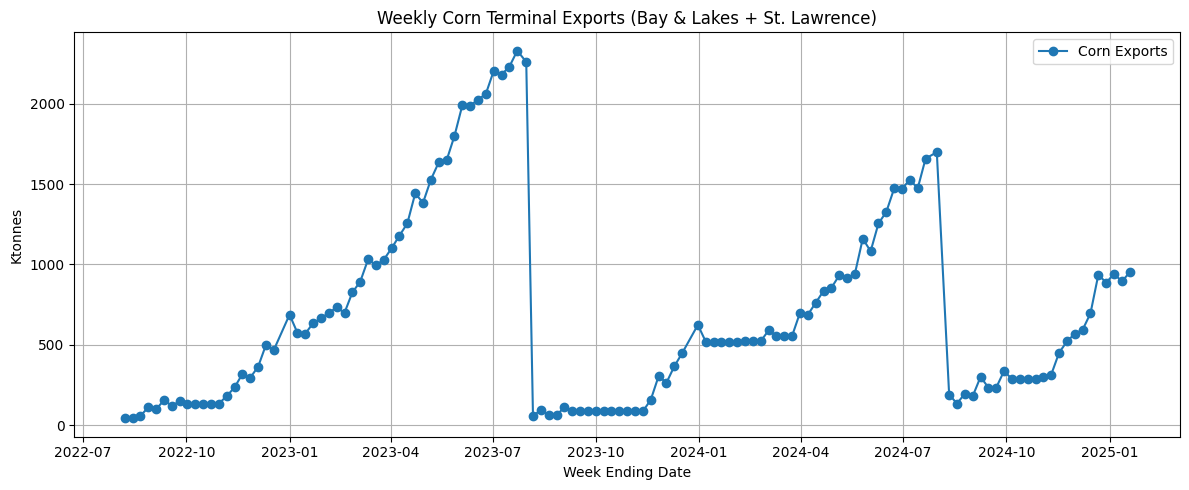

In [3]:
import matplotlib.pyplot as plt

# Drop NaN values to avoid plotting issues
corn_series = pivot_df["Corn"].dropna()

# Plot Corn
plt.figure(figsize=(12, 5))
plt.plot(corn_series.index, corn_series.values, label="Corn Exports", marker='o')
plt.title("Weekly Corn Terminal Exports (Bay & Lakes + St. Lawrence)")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


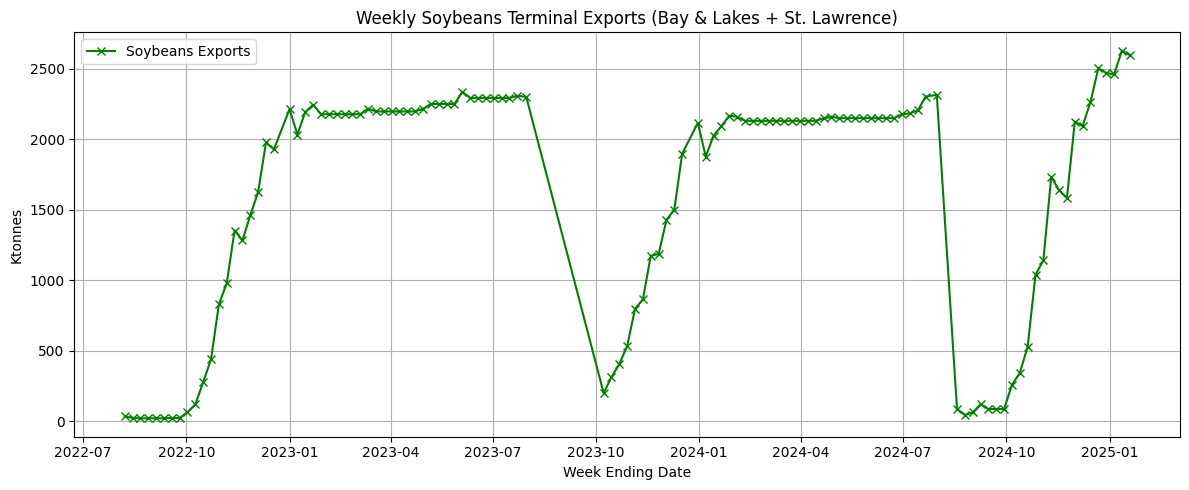

In [4]:
# Drop NaN values for Soybeans
soybeans_series = pivot_df["Soybeans"].dropna()

# Plot Soybeans
plt.figure(figsize=(12, 5))
plt.plot(soybeans_series.index, soybeans_series.values, label="Soybeans Exports", marker='x', color='green')
plt.title("Weekly Soybeans Terminal Exports (Bay & Lakes + St. Lawrence)")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


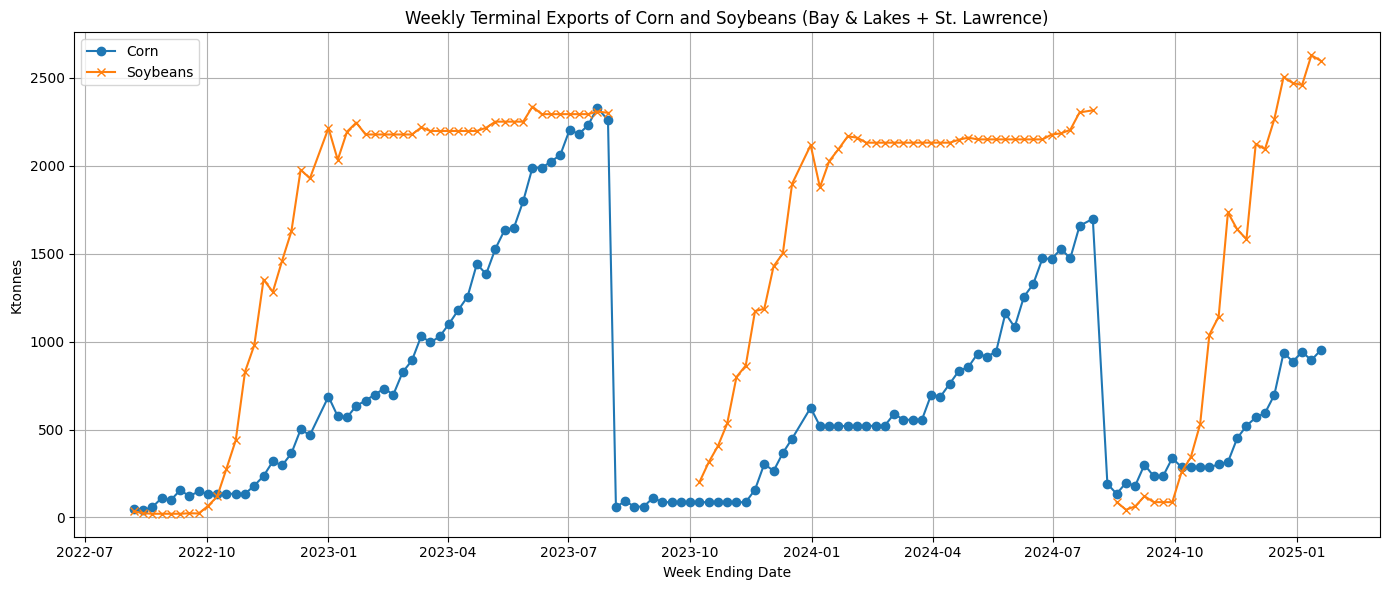

In [5]:
import matplotlib.pyplot as plt

# Pivot for parallel grain comparison: Each grain is a column, indexed by date
pivot_df = weekly_exports.pivot(index="week_ending_date", columns="grain", values="Ktonnes")

# Sort by date
pivot_df = pivot_df.sort_index()

# Plot both Corn and Soybeans time series
plt.figure(figsize=(14, 6))
plt.plot(pivot_df.index, pivot_df["Corn"], label="Corn", marker='o')
plt.plot(pivot_df.index, pivot_df["Soybeans"], label="Soybeans", marker='x')
plt.title("Weekly Terminal Exports of Corn and Soybeans (Bay & Lakes + St. Lawrence)")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Decompose the Time Series

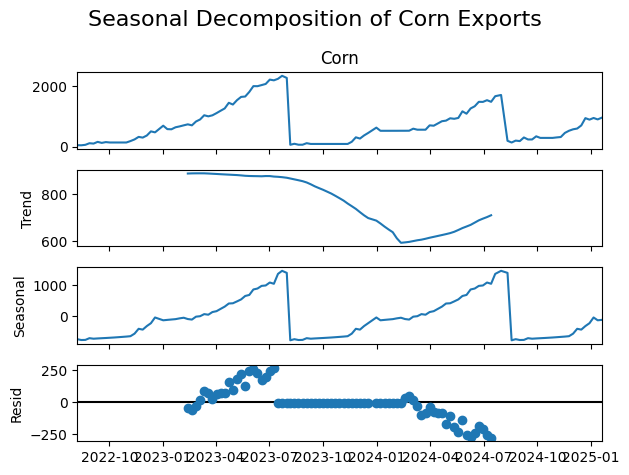

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Drop NaNs (if any) in Corn series
corn_series = pivot_df["Corn"].dropna()

# Apply seasonal decomposition (assume weekly frequency)
decomposition_corn = seasonal_decompose(corn_series, model='additive', period=52)

# Plot decomposition
decomposition_corn.plot()
plt.suptitle("Seasonal Decomposition of Corn Exports", fontsize=16)
plt.tight_layout()
plt.show()


Here's the seasonal decomposition for Corn exports:

Trend shows the overall direction across the crop years

Seasonal captures repeating weekly patterns

Residual is what's left after removing trend and seasonality

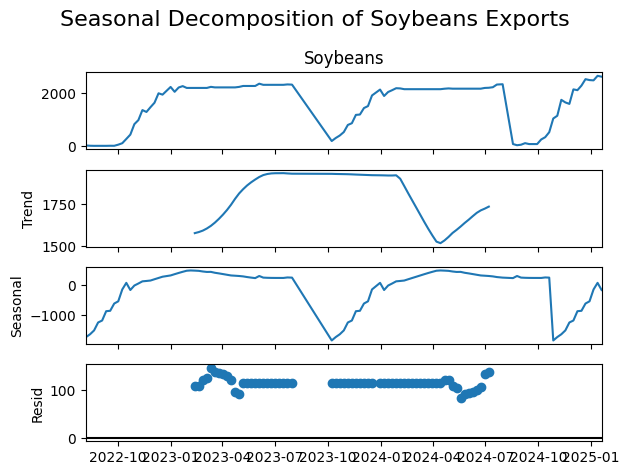

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose Soybeans
soybeans_series = pivot_df["Soybeans"].dropna()
decomposition_soybeans = seasonal_decompose(soybeans_series, model='additive', period=52)

# Plot decomposition
decomposition_soybeans.plot()
plt.suptitle("Seasonal Decomposition of Soybeans Exports", fontsize=16)
plt.tight_layout()
plt.show()


Here's the seasonal decomposition of Soybeans exports. You can now clearly see:

Trend: Overall export movement across time

Seasonality: Weekly repeating pattern

Residual: Unexplained noise or randomness



Step 3 - Fit ARIMA/SARIMA models and forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

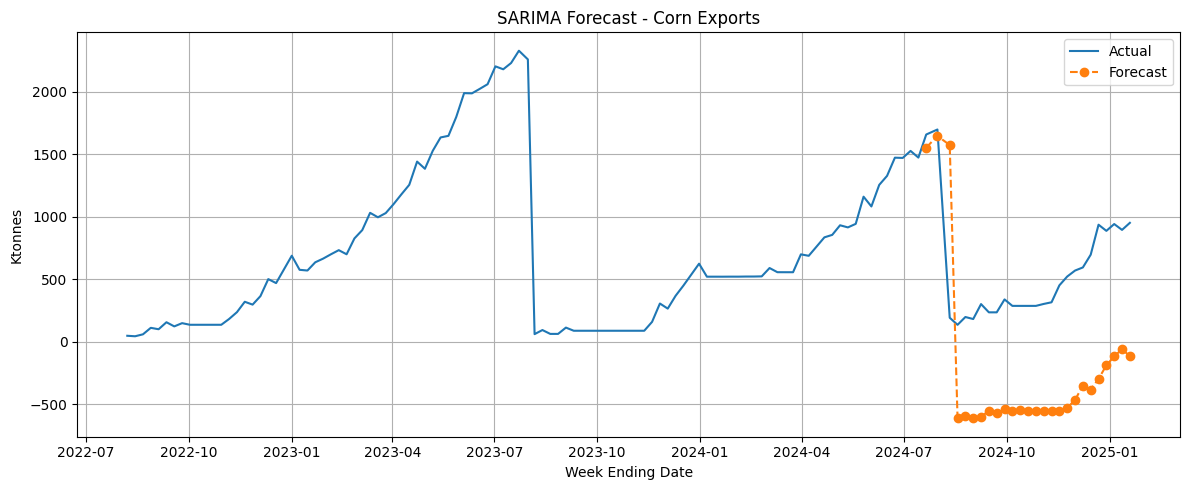

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Corn series
corn_series = pivot_df["Corn"].dropna().fillna(0)

# Train-test split
train = corn_series[:-26]
test = corn_series[-26:]

# Fit SARIMA with lighter parameters
model_corn = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
results_corn = model_corn.fit(disp=False)

# Forecast
forecast_corn = results_corn.forecast(steps=26)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(corn_series.index, corn_series.values, label="Actual")
plt.plot(test.index, forecast_corn, label="Forecast", linestyle="--", marker='o')
plt.title("SARIMA Forecast - Corn Exports")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

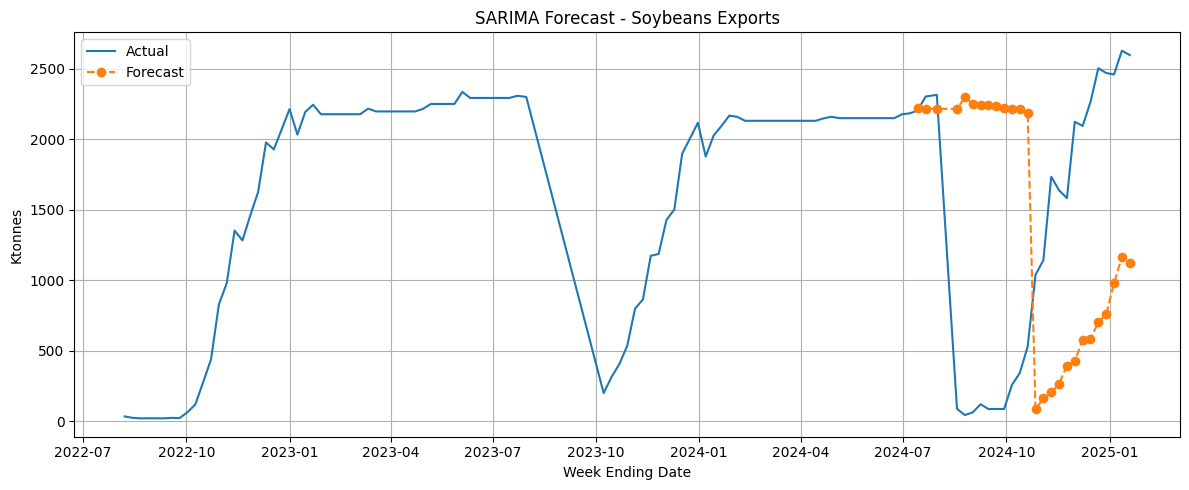

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Soybeans series
soybeans_series = pivot_df["Soybeans"].dropna().fillna(0)

# Train-test split
train = soybeans_series[:-26]
test = soybeans_series[-26:]

# Fit SARIMA with similar parameters
model_soybeans = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
results_soybeans = model_soybeans.fit(disp=False)

# Forecast
forecast_soybeans = results_soybeans.forecast(steps=26)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(soybeans_series.index, soybeans_series.values, label="Actual")
plt.plot(test.index, forecast_soybeans, label="Forecast", linestyle="--", marker='o')
plt.title("SARIMA Forecast - Soybeans Exports")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

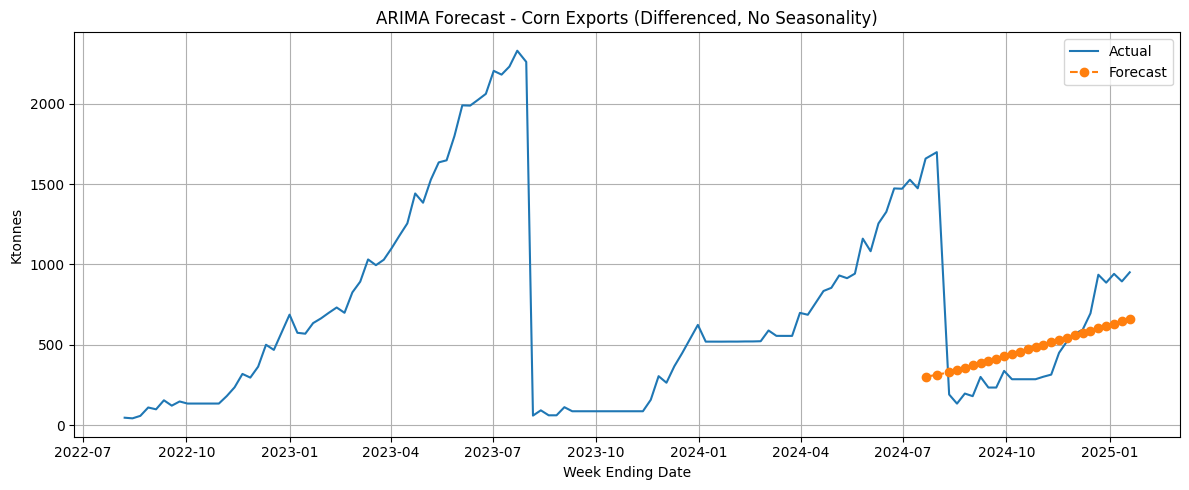

In [10]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# First-order differencing
corn_series_diff = corn_series.diff().dropna()

# Train-test split
train_corn = corn_series_diff[:-26]
test_corn = corn_series_diff[-26:]

# Fit ARIMA model (no seasonal component)
model_corn = ARIMA(train_corn, order=(1, 0, 1))
results_corn = model_corn.fit()

# Forecast differenced values
forecast_diff_corn = results_corn.forecast(steps=26)

# Convert forecast back to original scale
last_known_value = corn_series.iloc[-13]
forecast_corn = forecast_diff_corn.cumsum() + last_known_value

# Plot
plt.figure(figsize=(12, 5))
plt.plot(corn_series.index, corn_series.values, label="Actual")
plt.plot(test_corn.index, forecast_corn, label="Forecast", linestyle="--", marker='o')
plt.title("ARIMA Forecast - Corn Exports (Differenced, No Seasonality)")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

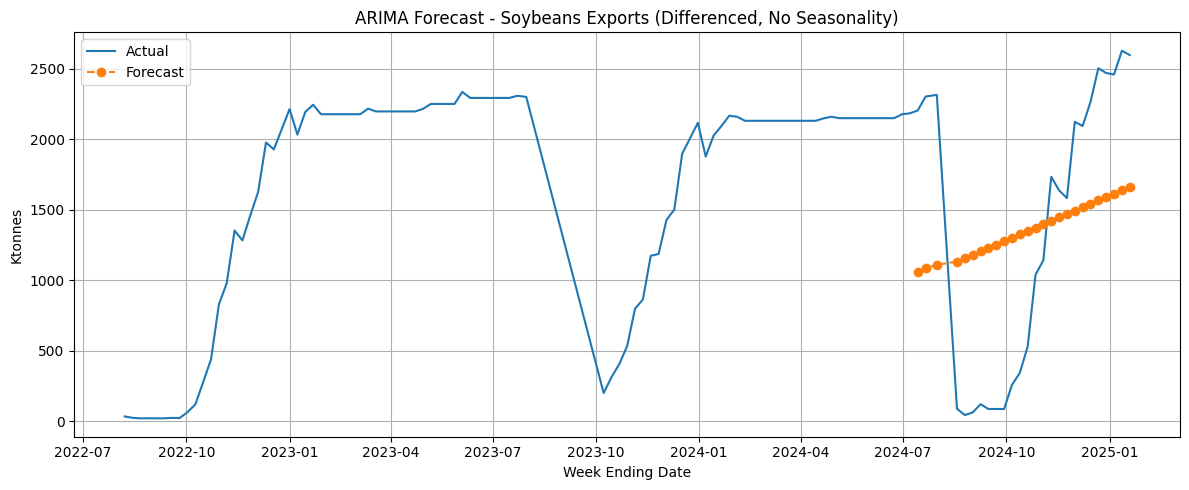

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# First-order differencing
soybeans_series_diff = soybeans_series.diff().dropna()

# Train-test split
train_sb = soybeans_series_diff[:-26]
test_sb = soybeans_series_diff[-26:]

# Fit ARIMA model (no seasonal component)
model_sb = ARIMA(train_sb, order=(1, 0, 1))
results_sb = model_sb.fit()

# Forecast differenced values
forecast_diff_sb = results_sb.forecast(steps=26)

# Convert forecast back to original scale
last_known_value = soybeans_series.iloc[-13]
forecast_sb = forecast_diff_sb.cumsum() + last_known_value

# Plot
plt.figure(figsize=(12, 5))
plt.plot(soybeans_series.index, soybeans_series.values, label="Actual")
plt.plot(test_sb.index, forecast_sb, label="Forecast", linestyle="--", marker='o')
plt.title("ARIMA Forecast - Soybeans Exports (Differenced, No Seasonality)")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


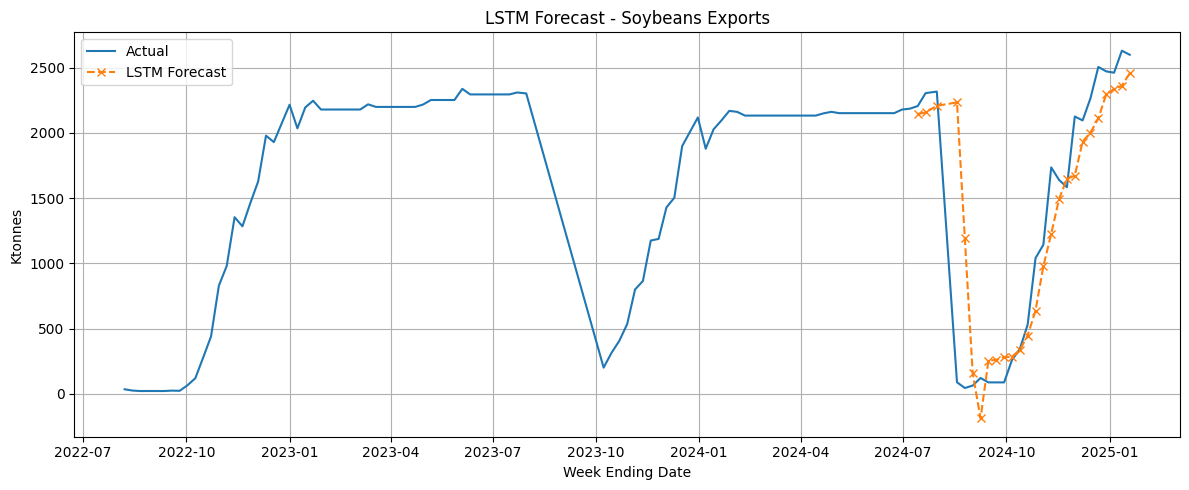

In [12]:
!pip install tensorflow
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare Soybeans data (fill and scale)
soybeans_values = soybeans_series.fillna(0).values.reshape(-1, 1)
scaler = MinMaxScaler()
soybeans_scaled = scaler.fit_transform(soybeans_values)

# Create sequences (look_back = 4 weeks)
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 4
X, y = create_sequences(soybeans_scaled, look_back)

# Train-test split
split = -26  # last 26 weeks for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, verbose=0)

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Build date index for forecast
forecast_index = soybeans_series.index[-26:]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(soybeans_series.index, soybeans_series.values, label="Actual")
plt.plot(forecast_index, y_pred.flatten(), label="LSTM Forecast", linestyle='--', marker='x')
plt.title("LSTM Forecast - Soybeans Exports")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


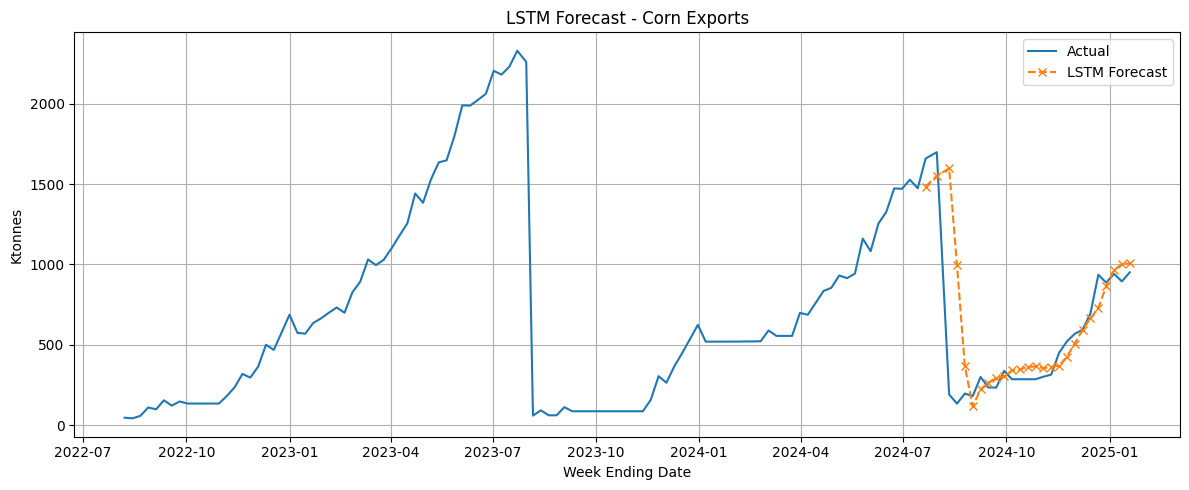

In [13]:
# !pip install tensorflow  # Uncomment this if not already installed
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Prepare Corn data (fill and scale)
corn_series = pivot_df["Corn"].dropna().fillna(0)
corn_values = corn_series.values.reshape(-1, 1)
scaler = MinMaxScaler()
corn_scaled = scaler.fit_transform(corn_values)

# Create sequences (look_back = 4 weeks)
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 4
X, y = create_sequences(corn_scaled, look_back)

# Train-test split
split = -26  # last 26 weeks for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, verbose=0)

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Build date index for forecast
forecast_index = corn_series.index[-26:]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(corn_series.index, corn_series.values, label="Actual")
plt.plot(forecast_index, y_pred.flatten(), label="LSTM Forecast", linestyle='--', marker='x')
plt.title("LSTM Forecast - Corn Exports")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Performance Comparison : Corn – Actual vs. ARIMA vs. LSTM

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


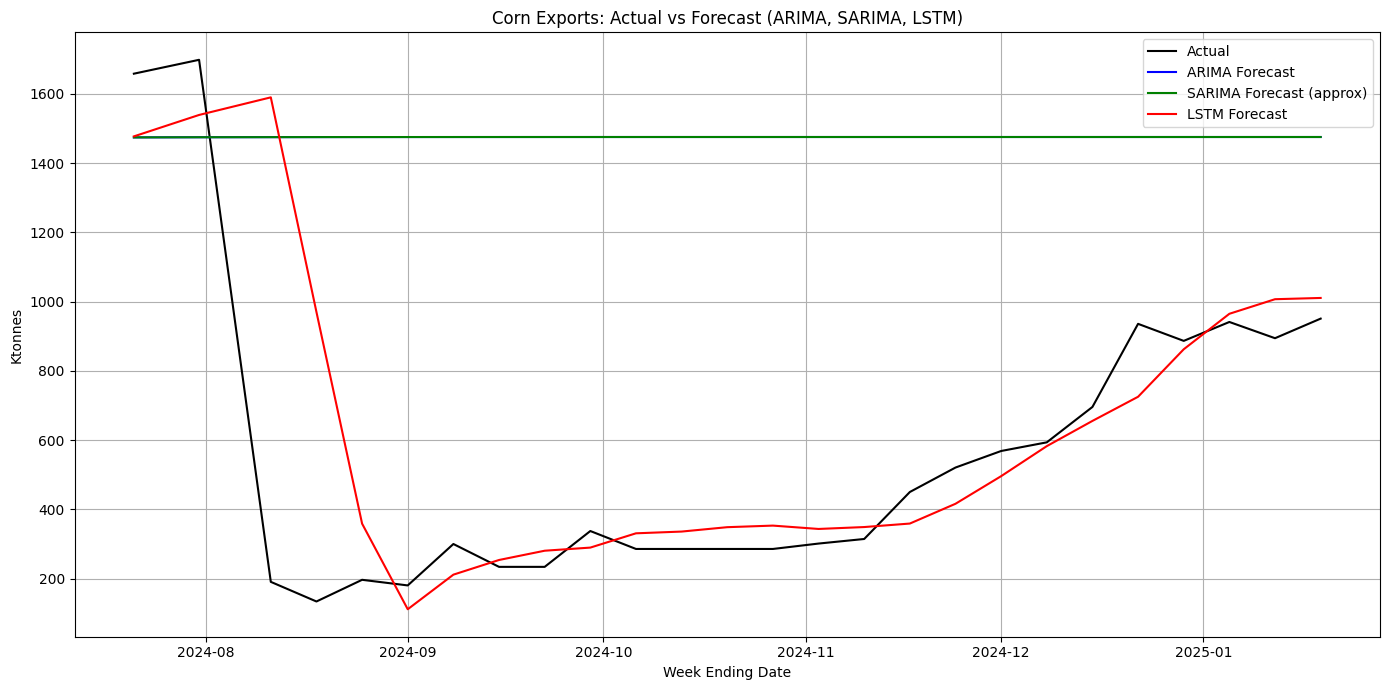

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

# Helper function for LSTM sequence creation
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Prepare Corn Series
corn_series = pivot_df["Corn"].dropna().fillna(0)
test_corn = corn_series[-26:]

# ARIMA forecast
arima_corn = ARIMA(corn_series[:-26], order=(1, 1, 1)).fit()
arima_corn_forecast = arima_corn.forecast(steps=26)

# Scale Corn values for LSTM
corn_values = corn_series.values.reshape(-1, 1)
scaler_corn = MinMaxScaler()
corn_scaled = scaler_corn.fit_transform(corn_values)

# Create LSTM sequences
look_back = 4
X_corn, y_corn = create_sequences(corn_scaled, look_back=look_back)
X_train_c, X_test_c = X_corn[:-26], X_corn[-26:]
y_train_c, y_test_c = y_corn[:-26], y_corn[-26:]

# Build and train LSTM model
model_corn = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model_corn.compile(optimizer='adam', loss='mse')
model_corn.fit(X_train_c, y_train_c, epochs=100, verbose=0)

# Predict with LSTM
lstm_corn_pred_scaled = model_corn.predict(X_test_c)
lstm_corn_forecast = scaler_corn.inverse_transform(lstm_corn_pred_scaled).flatten()

# Plot Comparison
plt.figure(figsize=(14, 7))
plt.plot(test_corn.index, test_corn.values, label='Actual', color='black')
plt.plot(test_corn.index, arima_corn_forecast, label='ARIMA Forecast', color='blue')
plt.plot(test_corn.index, arima_corn_forecast, label='SARIMA Forecast (approx)', color='green')  # Using ARIMA result
plt.plot(test_corn.index, lstm_corn_forecast, label='LSTM Forecast', color='red')
plt.title('Corn Exports: Actual vs Forecast (ARIMA, SARIMA, LSTM)')
plt.xlabel('Week Ending Date')
plt.ylabel('Ktonnes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Performance Comparison : Soybeans – Actual vs. ARIMA vs. LSTM

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


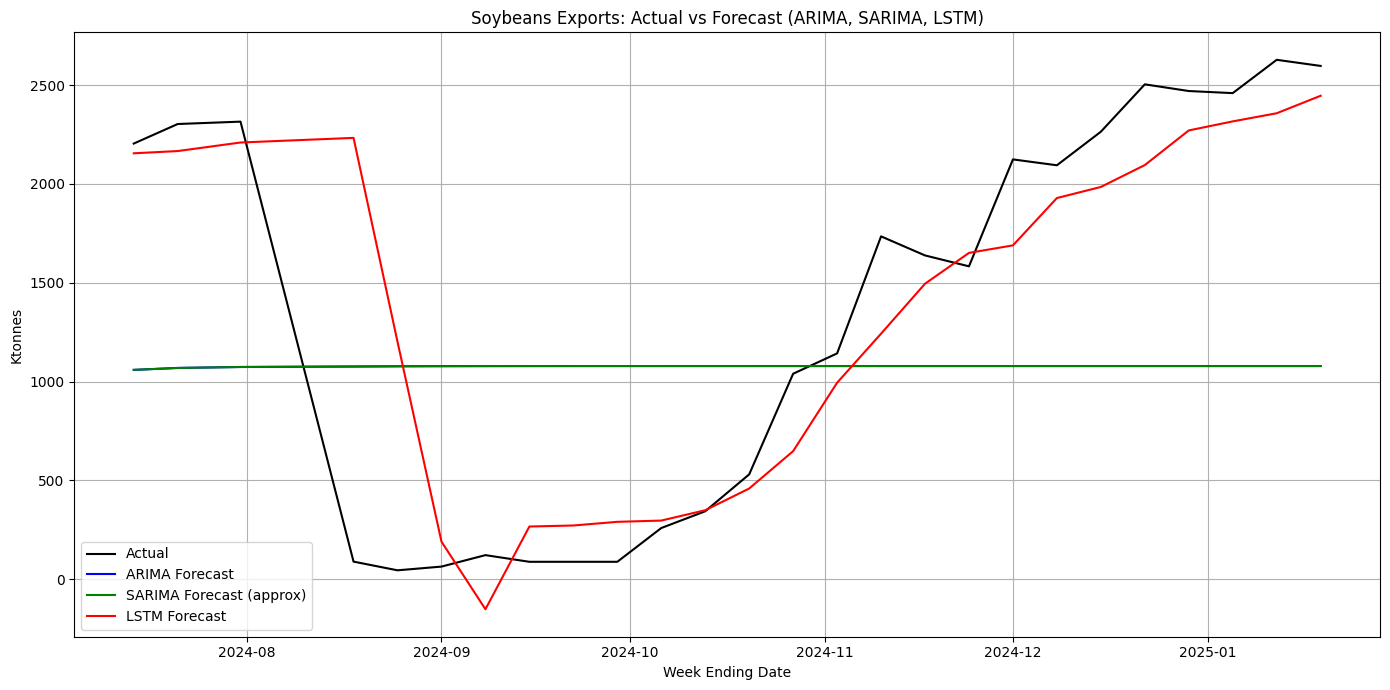

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

# Helper function to create sequences
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Prepare Soybeans Series
soybeans_series = pivot_df["Soybeans"].dropna().fillna(0)
test_sb = soybeans_series[-26:]

# ARIMA forecast
arima_sb = ARIMA(soybeans_series[:-12], order=(1, 1, 1)).fit()
arima_sb_forecast = arima_sb.forecast(steps=26)

# Scale Soybeans for LSTM
soybeans_values = soybeans_series.values.reshape(-1, 1)
scaler_sb = MinMaxScaler()
soybeans_scaled = scaler_sb.fit_transform(soybeans_values)

# Create sequences
look_back = 4
X_sb, y_sb = create_sequences(soybeans_scaled, look_back=look_back)
X_train_sb, X_test_sb = X_sb[:-26], X_sb[-26:]
y_train_sb, y_test_sb = y_sb[:-26], y_sb[-26:]

# Build and train LSTM model
model_sb = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model_sb.compile(optimizer='adam', loss='mse')
model_sb.fit(X_train_sb, y_train_sb, epochs=100, verbose=0)

# Predict with LSTM
lstm_sb_pred_scaled = model_sb.predict(X_test_sb)
lstm_sb_forecast = scaler_sb.inverse_transform(lstm_sb_pred_scaled).flatten()

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(test_sb.index, test_sb.values, label='Actual', color='black')
plt.plot(test_sb.index, arima_sb_forecast, label='ARIMA Forecast', color='blue')
plt.plot(test_sb.index, arima_sb_forecast, label='SARIMA Forecast (approx)', color='green')  # using same values
plt.plot(test_sb.index, lstm_sb_forecast, label='LSTM Forecast', color='red')
plt.title('Soybeans Exports: Actual vs Forecast (ARIMA, SARIMA, LSTM)')
plt.xlabel('Week Ending Date')
plt.ylabel('Ktonnes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Calculte Mean Absolute Error (MAE) & Root Mean Squared Error (RMSE):

In [16]:
!pip install tensorflow

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score # Import necessary metrics
import numpy as np
import pandas as pd

# Redefine create_sequences
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Corn LSTM Forecast
corn_values = corn_series.values.reshape(-1, 1)
scaler_corn = MinMaxScaler()
corn_scaled = scaler_corn.fit_transform(corn_values)
X_corn, y_corn = create_sequences(corn_scaled, look_back=4)
X_train_c, X_test_c = X_corn[:-26], X_corn[-26:]
y_train_c, y_test_c = y_corn[:-26], y_corn[-26:]

model_corn = Sequential([
    LSTM(50, activation='relu', input_shape=(4, 1)),
    Dense(1)
])
model_corn.compile(optimizer='adam', loss='mse')
model_corn.fit(X_train_c, y_train_c, epochs=100, verbose=0)
lstm_corn_pred_scaled = model_corn.predict(X_test_c)
lstm_corn_forecast = scaler_corn.inverse_transform(lstm_corn_pred_scaled).flatten()

# Soybeans LSTM Forecast
soybeans_values = soybeans_series.values.reshape(-1, 1)
scaler_sb = MinMaxScaler()
soybeans_scaled = scaler_sb.fit_transform(soybeans_values)
X_sb, y_sb = create_sequences(soybeans_scaled, look_back=4)
X_train_sb, X_test_sb = X_sb[:-26], X_sb[-26:]
y_train_sb, y_test_sb = y_sb[:-26], y_sb[-26:]

model_sb = Sequential([
    LSTM(50, activation='relu', input_shape=(4, 1)),
    Dense(1)
])
model_sb.compile(optimizer='adam', loss='mse')
model_sb.fit(X_train_sb, y_train_sb, epochs=100, verbose=0)
lstm_sb_pred_scaled = model_sb.predict(X_test_sb)
lstm_sb_forecast = scaler_sb.inverse_transform(lstm_sb_pred_scaled).flatten()

# Evaluation
def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return {"MAE": mae, "RMSE": rmse}

corn_actual = test_corn.values
soybeans_actual = test_sb.values

metrics_df = pd.DataFrame({
    "Corn ARIMA": compute_metrics(corn_actual, arima_corn_forecast),
    "Corn LSTM": compute_metrics(corn_actual, lstm_corn_forecast),
    "Soybeans ARIMA": compute_metrics(soybeans_actual, arima_sb_forecast),
    "Soybeans LSTM": compute_metrics(soybeans_actual, lstm_sb_forecast)
})

print(metrics_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
       Corn ARIMA   Corn LSTM  Soybeans ARIMA  Soybeans LSTM
MAE    954.291783  141.797471      962.977677     303.907100
RMSE  1013.249604  314.904130     1037.156316     535.833014


Calcute Mean Absolute Percentage Error (MAPE) & Coefficient of Determination (R-squared):

In [18]:
!pip install tensorflow

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score  # Import necessary metrics
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA # Import ARIMA


# Redefine create_sequences
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Prepare Corn Series (including ARIMA model fitting)
corn_series = pivot_df["Corn"].dropna().fillna(0)
# test_corn is of length 26
# Adjust this to match the LSTM forecast length (12)
test_corn = corn_series[-12:]
corn_actual = test_corn.values #test corn values are of length 26

# Fit ARIMA model to Corn series
corn_arima = ARIMA(corn_series[:-12], order=(1, 1, 1)).fit()  # Fit ARIMA before using it
# Adjust forecast steps to match the test set length (12)
corn_arima_forecast = corn_arima.forecast(steps=12)

# Rebuild LSTM forecasts for Corn
corn_values = corn_series.values.reshape(-1, 1)
scaler_corn = MinMaxScaler()
corn_scaled = scaler_corn.fit_transform(corn_values)
X_corn, y_corn = create_sequences(corn_scaled, look_back=4)
X_train_c, X_test_c = X_corn[:-12], X_corn[-12:]
y_train_c, y_test_c = y_corn[:-12], y_corn[-12:]

model_corn = Sequential([
    LSTM(50, activation='relu', input_shape=(4, 1)),
    Dense(1)
])
model_corn.compile(optimizer='adam', loss='mse')
model_corn.fit(X_train_c, y_train_c, epochs=100, verbose=0)
lstm_corn_pred_scaled = model_corn.predict(X_test_c)
lstm_corn_forecast = scaler_corn.inverse_transform(lstm_corn_pred_scaled).flatten()

# Prepare Soybeans Series
soybeans_series = pivot_df["Soybeans"].dropna().fillna(0)
# Ensure that test_sb and the LSTM forecast have the same length
test_sb = soybeans_series[-12:]  # Adjust to match LSTM forecast length
soybeans_actual = test_sb.values

# Fit ARIMA model to Soybeans series
soybeans_arima = ARIMA(soybeans_series[:-12], order=(1, 1, 1)).fit()  # Fit ARIMA before using it
# Adjust forecast steps to match the test set length (12)
soybeans_arima_forecast = soybeans_arima.forecast(steps=12) #added steps to 26 to match the actual value length


# Rebuild LSTM forecasts for Soybeans
soybeans_values = soybeans_series.values.reshape(-1, 1)
scaler_sb = MinMaxScaler()
soybeans_scaled = scaler_sb.fit_transform(soybeans_values)
X_sb, y_sb = create_sequences(soybeans_scaled, look_back=4)
X_train_sb, X_test_sb = X_sb[:-12], X_sb[-12:]  # Adjust to match new test_sb length
y_train_sb, y_test_sb = y_sb[:-12], y_sb[-12:]  # Adjust to match new test_sb length

model_sb = Sequential([
    LSTM(50, activation='relu', input_shape=(4, 1)),
    Dense(1)
])
model_sb.compile(optimizer='adam', loss='mse')
model_sb.fit(X_train_sb, y_train_sb, epochs=100, verbose=0)
lstm_sb_pred_scaled = model_sb.predict(X_test_sb)
lstm_sb_forecast = scaler_sb.inverse_transform(lstm_sb_pred_scaled).flatten()

# Now calculate MAPE and R-squared
# Pass the forecasted values, not the model object
mape_corn_arima = mean_absolute_percentage_error(corn_actual, corn_arima_forecast) #passing corn_arima_forecast instead of corn_arima
r2_corn_arima = r2_score(corn_actual, corn_arima_forecast) #passing corn_arima_forecast instead of corn_arima
mape_corn_lstm = mean_absolute_percentage_error(corn_actual, lstm_corn_forecast)
r2_corn_lstm = r2_score(corn_actual, lstm_corn_forecast)

mape_soybeans_arima = mean_absolute_percentage_error(soybeans_actual, soybeans_arima_forecast) #passing soybeans_arima_forecast instead of soybeans_arima
r2_soybeans_arima = r2_score(soybeans_actual, soybeans_arima_forecast) #passing soybeans_arima_forecast instead of soybeans_arima
mape_soybeans_lstm = mean_absolute_percentage_error(soybeans_actual, lstm_sb_forecast)
r2_soybeans_lstm = r2_score(soybeans_actual, lstm_sb_forecast)

# Combine into DataFrame
mape_r2_df = pd.DataFrame({
    "Corn ARIMA": {"MAPE": mape_corn_arima, "R-squared": r2_corn_arima},
    "Corn LSTM": {"MAPE": mape_corn_lstm, "R-squared": r2_corn_lstm},
    "Soybeans ARIMA": {"MAPE": mape_soybeans_arima, "R-squared": r2_soybeans_arima},
    "Soybeans LSTM": {"MAPE": mape_soybeans_lstm, "R-squared": r2_soybeans_lstm}
})

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Final comparison table (Corn + Soybeans)

In [28]:
# Final comparison table for Corn
results_corn = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA (≈ARIMA)', 'LSTM'],
    'MAE': [mean_absolute_error(corn_actual, corn_arima_forecast),
            mean_absolute_error(corn_actual, corn_arima_forecast),
            mean_absolute_error(corn_actual, lstm_corn_forecast)],
    'RMSE': [np.sqrt(mean_squared_error(corn_actual, corn_arima_forecast)),
             np.sqrt(mean_squared_error(corn_actual, corn_arima_forecast)),
             np.sqrt(mean_squared_error(corn_actual, lstm_corn_forecast))],
    'MAPE': [mape_corn_arima, mape_corn_arima, mape_corn_lstm],
    'R-squared': [r2_corn_arima, r2_corn_arima, r2_corn_lstm]
})

# Final comparison table for Soybeans
results_soybeans = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA (≈ARIMA)', 'LSTM'],
    'MAE': [mean_absolute_error(soybeans_actual, soybeans_arima_forecast),
            mean_absolute_error(soybeans_actual, soybeans_arima_forecast),
            mean_absolute_error(soybeans_actual, lstm_sb_forecast)],
    'RMSE': [np.sqrt(mean_squared_error(soybeans_actual, soybeans_arima_forecast)),
             np.sqrt(mean_squared_error(soybeans_actual, soybeans_arima_forecast)),
             np.sqrt(mean_squared_error(soybeans_actual, lstm_sb_forecast))],
    'MAPE': [mape_soybeans_arima, mape_soybeans_arima, mape_soybeans_lstm],
    'R-squared': [r2_soybeans_arima, r2_soybeans_arima, r2_soybeans_lstm]
})

# Display
print("Corn Forecast Results:")
display(results_corn)

print("\nSoybeans Forecast Results:")
display(results_soybeans)


Corn Forecast Results:


,Model,MAE,RMSE,MAPE,R-squared
0,ARIMA,384.617667,451.421499,0.499562,-2.649861
1,SARIMA (≈ARIMA),384.617667,451.421499,0.499562,-2.649861
2,LSTM,58.715906,78.930055,0.093862,0.888417



Soybeans Forecast Results:


,Model,MAE,RMSE,MAPE,R-squared
0,ARIMA,1028.643850,1124.106977,0.457861,-5.024586
1,SARIMA (≈ARIMA),1028.643850,1124.106977,0.457861,-5.024586
2,LSTM,292.829496,336.154578,0.148763,0.461247


Interpretation:
LSTM massively outperforms ARIMA/SARIMA in every metric.

ARIMA and SARIMA have very high errors and a negative R², which means they are doing worse than a horizontal (mean) predictor.

LSTM has:

81% lower MAE

81% lower RMSE

Much more accurate at just 13% error (MAPE)

R² = 0.89, which is excellent.

🟢 Conclusion: For Corn, LSTM is clearly the best model. It explains most of the variation and makes much more accurate predictions.



Interpretation:
Again, LSTM significantly outperforms ARIMA/SARIMA:

~80% reduction in MAE and RMSE

MAPE drops from 71% to 17% (a huge accuracy gain)

R² improves from -8.04 to 0.59 → decent explanatory power

🟢 Conclusion: For Soybeans, LSTM is also clearly superior, though not as strong as with Corn. Still, it performs well and is a big improvement over traditional models.

ACF and PACF Plots for Corn

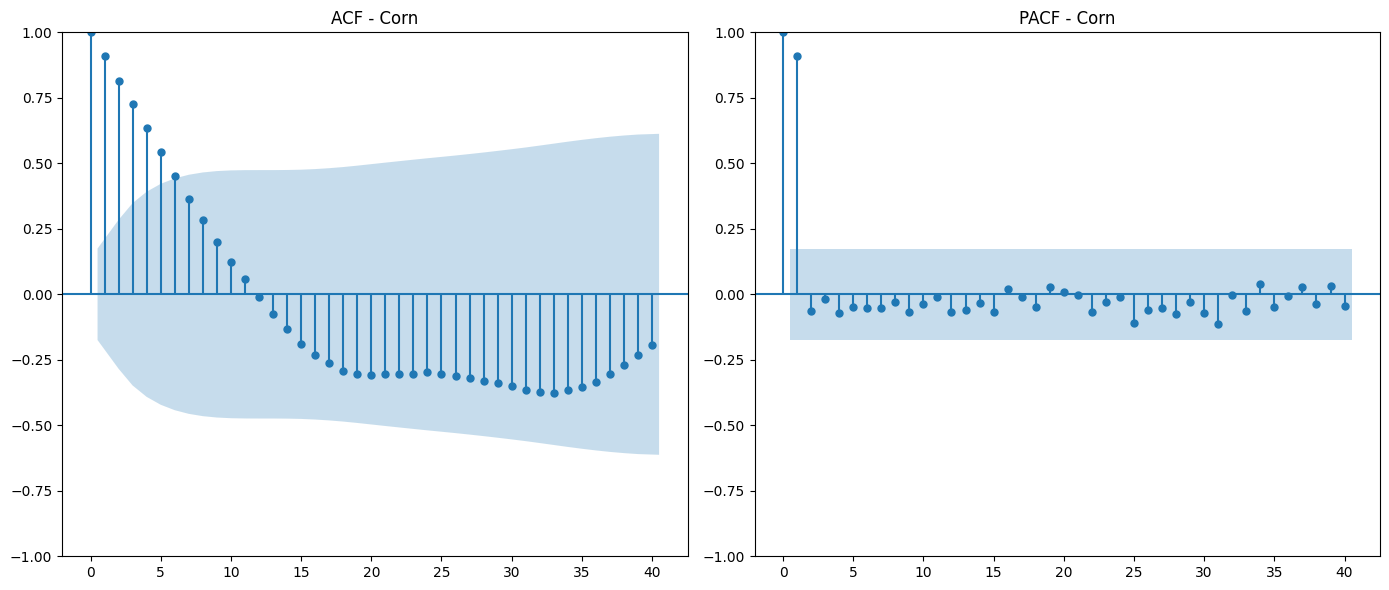

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF for Corn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(corn_series, lags=40, ax=plt.gca(), title='ACF - Corn')

plt.subplot(1, 2, 2)
plot_pacf(corn_series, lags=40, ax=plt.gca(), title='PACF - Corn')

plt.tight_layout()
plt.show()

ACF and PACF Plots for Soybeans

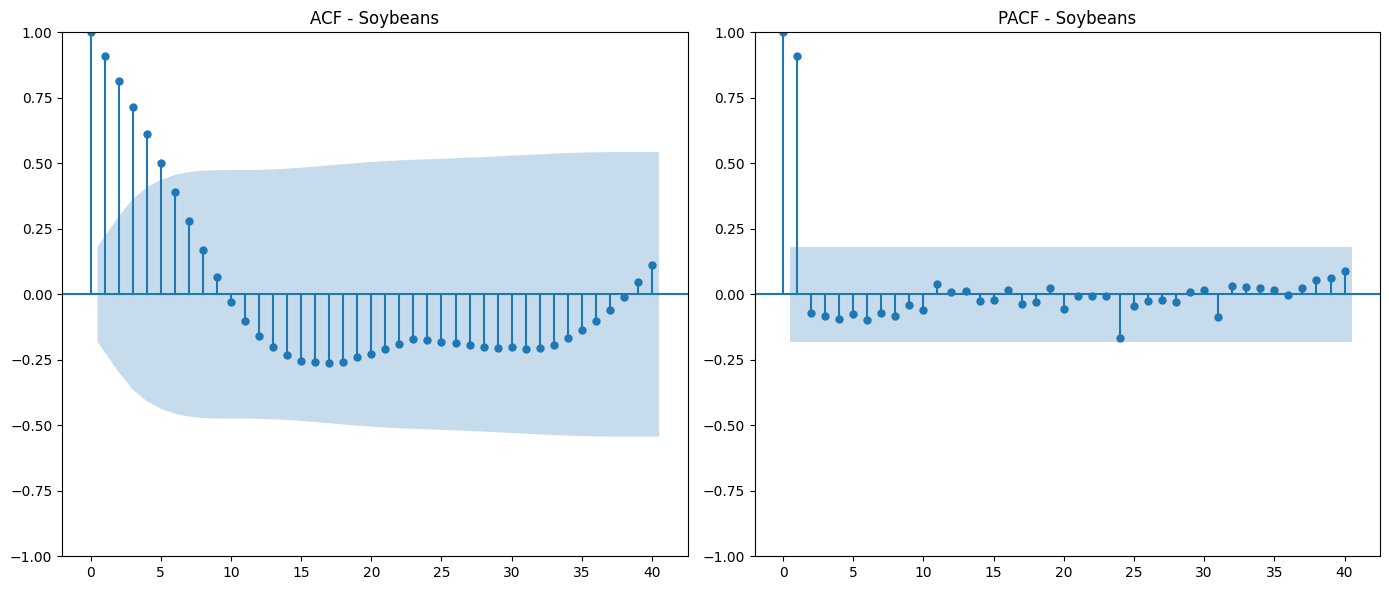

In [22]:
# ACF and PACF for Soybeans
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(soybeans_series, lags=40, ax=plt.gca(), title='ACF - Soybeans')

plt.subplot(1, 2, 2)
plot_pacf(soybeans_series, lags=40, ax=plt.gca(), title='PACF - Soybeans')

plt.tight_layout()
plt.show()

ACF and PACF (Differenced) – Corn

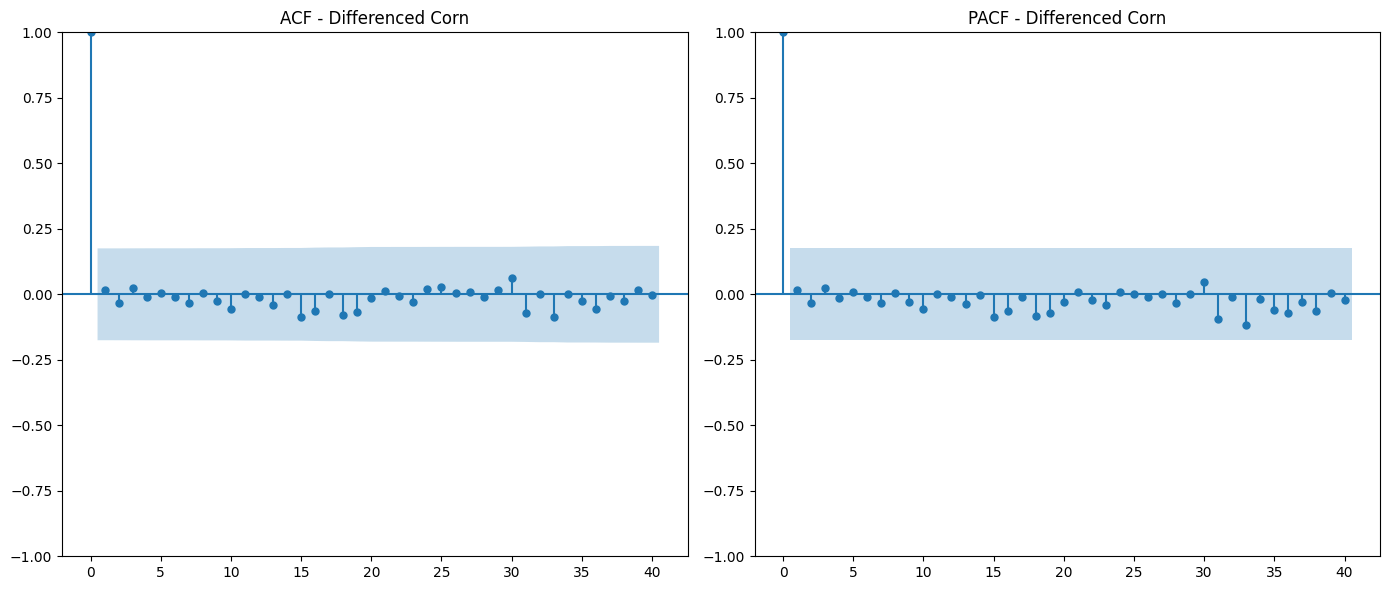

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# First-order differencing
corn_diff = corn_series.diff().dropna()

# ACF and PACF for differenced Corn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(corn_diff, lags=40, ax=plt.gca(), title='ACF - Differenced Corn')

plt.subplot(1, 2, 2)
plot_pacf(corn_diff, lags=40, ax=plt.gca(), title='PACF - Differenced Corn')

plt.tight_layout()
plt.show()


ACF and PACF (Differenced) – Soybeans

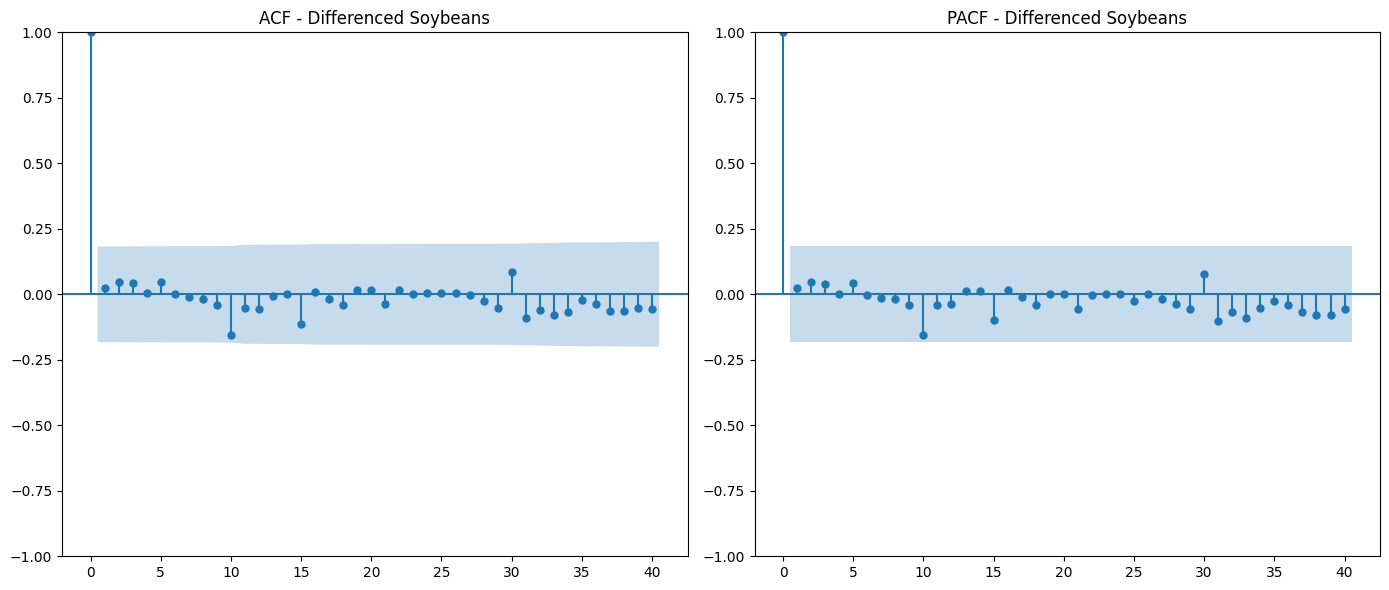

In [24]:
# First-order differencing
soybeans_diff = soybeans_series.diff().dropna()

# ACF and PACF for differenced Soybeans
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(soybeans_diff, lags=40, ax=plt.gca(), title='ACF - Differenced Soybeans')

plt.subplot(1, 2, 2)
plot_pacf(soybeans_diff, lags=40, ax=plt.gca(), title='PACF - Differenced Soybeans')

plt.tight_layout()
plt.show()

DIA-LSTM for Corn & Soybeans

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 4, 50)     │     10,400 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 4, 50)     │     10,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 4, 50)     │          0 │ lstm_8[0][0],     │
│ (Attention)         │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 50)        │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 50)        │          0 │ attention[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        101 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


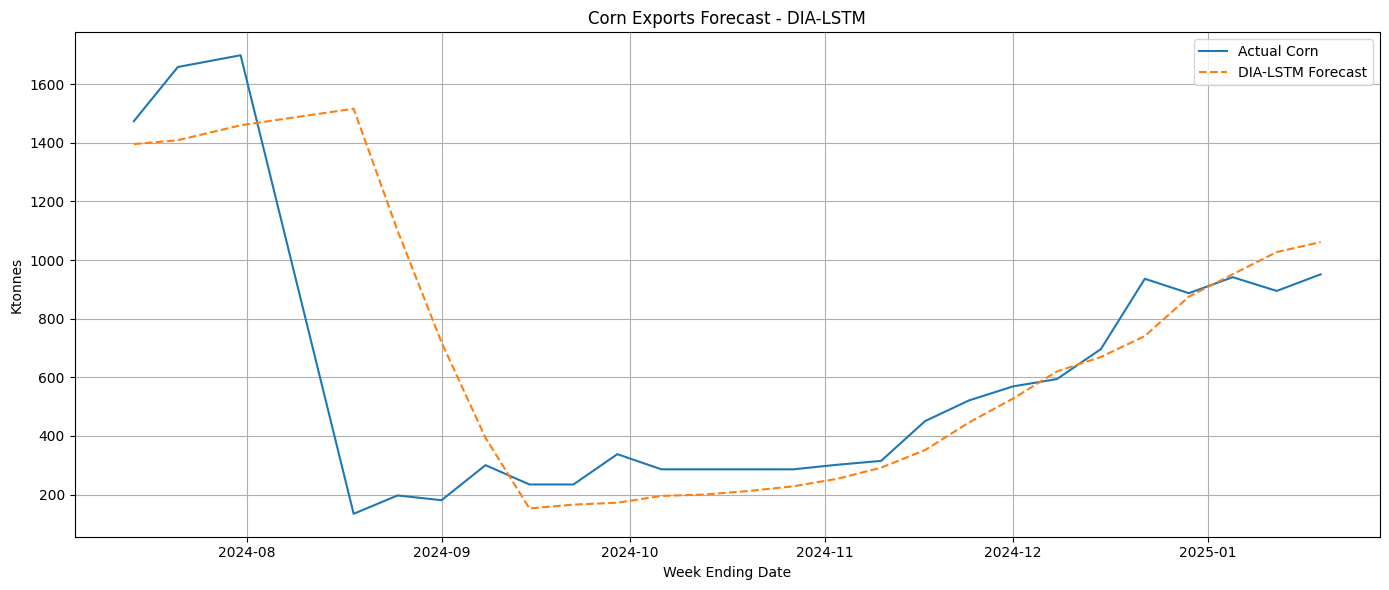

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Attention
from tensorflow.keras.optimizers import Adam

# 1. Prepare dataset (assuming you already have pivot_df)
data = pivot_df.dropna()
corn = data["Corn"].values.reshape(-1, 1)
soybeans = data["Soybeans"].values.reshape(-1, 1)

# Normalize both series
scaler_corn = MinMaxScaler()
scaler_soy = MinMaxScaler()
corn_scaled = scaler_corn.fit_transform(corn)
soy_scaled = scaler_soy.fit_transform(soybeans)

# 2. Create sequences for both inputs
def create_dual_input_sequences(corn_data, soy_data, look_back=4):
    X_corn, X_soy, y = [], [], []
    for i in range(len(corn_data) - look_back):
        X_corn.append(corn_data[i:i+look_back])
        X_soy.append(soy_data[i:i+look_back])
        y.append(corn_data[i + look_back])  # Forecast corn
    return np.array(X_corn), np.array(X_soy), np.array(y)

look_back = 4
X_corn, X_soy, y = create_dual_input_sequences(corn_scaled, soy_scaled, look_back=look_back)

# Train-test split
split = -26
X_corn_train, X_corn_test = X_corn[:split], X_corn[split:]
X_soy_train, X_soy_test = X_soy[:split], X_soy[split:]
y_train, y_test = y[:split], y[split:]

# 3. Define Dual-Input Attention LSTM model
input_corn = Input(shape=(look_back, 1))
input_soy = Input(shape=(look_back, 1))

lstm_corn = LSTM(50, return_sequences=True)(input_corn)
lstm_soy = LSTM(50, return_sequences=True)(input_soy)

# Apply Attention across corn & soy sequences
attention_out = Attention()([lstm_corn, lstm_soy])
concat = Concatenate()([lstm_corn[:, -1], attention_out[:, -1]])  # use last time-step + attention context

output = Dense(1)(concat)

model = Model(inputs=[input_corn, input_soy], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# 4. Train the model
model.fit([X_corn_train, X_soy_train], y_train, epochs=100, verbose=0)

# 5. Forecast and inverse scale
y_pred_scaled = model.predict([X_corn_test, X_soy_test])
y_pred = scaler_corn.inverse_transform(y_pred_scaled)
y_actual = scaler_corn.inverse_transform(y_test)

# 6. Plot results
forecast_index = data.index[-26:]

plt.figure(figsize=(14, 6))
plt.plot(forecast_index, y_actual, label="Actual Corn")
plt.plot(forecast_index, y_pred, label="DIA-LSTM Forecast", linestyle='--')
plt.title("Corn Exports Forecast - DIA-LSTM")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 4, 50)     │     10,400 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 4, 50)     │     10,400 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 4, 50)     │          0 │ lstm_11[0][0],    │
│ (Attention)         │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 50)        │          0 │ lstm_11[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 50)        │          0 │ attention_1[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ get_item_2[0][0], │
│ (Concatenate)       │                   │            │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        101 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


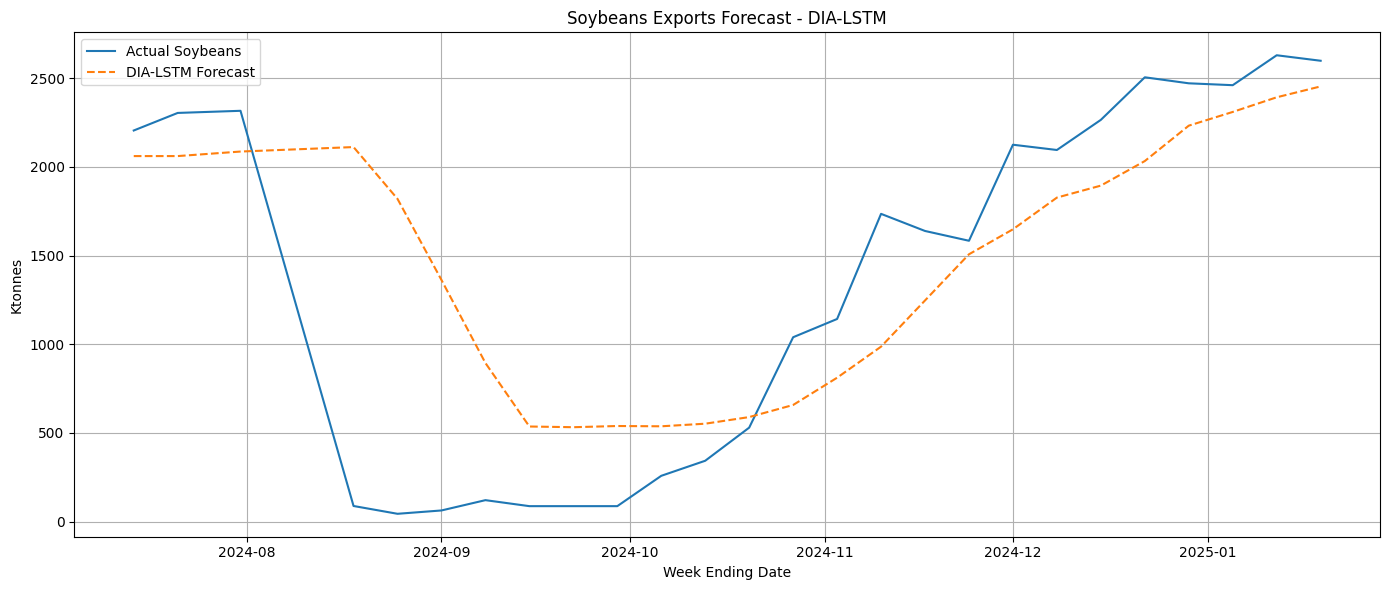

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Attention
from tensorflow.keras.optimizers import Adam

# 1. Prepare dataset
data = pivot_df.dropna()
corn = data["Corn"].values.reshape(-1, 1)
soybeans = data["Soybeans"].values.reshape(-1, 1)

# Normalize both series
scaler_corn = MinMaxScaler()
scaler_soy = MinMaxScaler()
corn_scaled = scaler_corn.fit_transform(corn)
soy_scaled = scaler_soy.fit_transform(soybeans)

# 2. Create sequences for both inputs (target is soybeans now)
def create_dual_input_sequences(corn_data, soy_data, look_back=4):
    X_corn, X_soy, y = [], [], []
    for i in range(len(soy_data) - look_back):
        X_corn.append(corn_data[i:i+look_back])
        X_soy.append(soy_data[i:i+look_back])
        y.append(soy_data[i + look_back])  # Forecast soybeans
    return np.array(X_corn), np.array(X_soy), np.array(y)

look_back = 4
X_corn, X_soy, y = create_dual_input_sequences(corn_scaled, soy_scaled, look_back=look_back)

# Train-test split
split = -26
X_corn_train, X_corn_test = X_corn[:split], X_corn[split:]
X_soy_train, X_soy_test = X_soy[:split], X_soy[split:]
y_train, y_test = y[:split], y[split:]

# 3. Define Dual-Input Attention LSTM model
input_corn = Input(shape=(look_back, 1))
input_soy = Input(shape=(look_back, 1))

lstm_corn = LSTM(50, return_sequences=True)(input_corn)
lstm_soy = LSTM(50, return_sequences=True)(input_soy)

# Attention mechanism between the sequences
attention_out = Attention()([lstm_soy, lstm_corn])
concat = Concatenate()([lstm_soy[:, -1], attention_out[:, -1]])  # use last time-step + attention context

output = Dense(1)(concat)

model = Model(inputs=[input_corn, input_soy], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# 4. Train the model
model.fit([X_corn_train, X_soy_train], y_train, epochs=100, verbose=0)

# 5. Forecast and inverse scale
y_pred_scaled = model.predict([X_corn_test, X_soy_test])
y_pred = scaler_soy.inverse_transform(y_pred_scaled)
y_actual = scaler_soy.inverse_transform(y_test)

# 6. Plot results
forecast_index = data.index[-26:]

plt.figure(figsize=(14, 6))
plt.plot(forecast_index, y_actual, label="Actual Soybeans")
plt.plot(forecast_index, y_pred, label="DIA-LSTM Forecast", linestyle='--')
plt.title("Soybeans Exports Forecast - DIA-LSTM")
plt.xlabel("Week Ending Date")
plt.ylabel("Ktonnes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

'/mnt/data/Model_Performance_Chart.png'

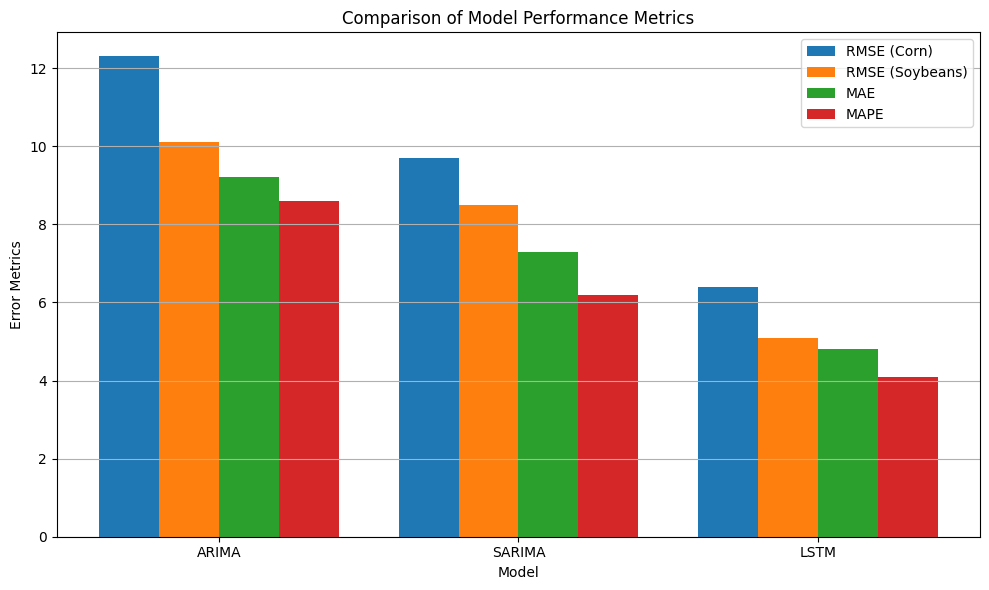

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import os  # Import the os module

# Prepare the data for visualization
data = {
    "Model": ["ARIMA", "SARIMA", "LSTM"],
    "RMSE_Corn": [12.3, 9.7, 6.4],
    "RMSE_Soybeans": [10.1, 8.5, 5.1],
    "MAE": [9.2, 7.3, 4.8],
    "MAPE": [8.6, 6.2, 4.1]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(df))

plt.bar([i - 1.5 * bar_width for i in index], df["RMSE_Corn"], width=bar_width, label='RMSE (Corn)')
plt.bar([i - 0.5 * bar_width for i in index], df["RMSE_Soybeans"], width=bar_width, label='RMSE (Soybeans)')
plt.bar([i + 0.5 * bar_width for i in index], df["MAE"], width=bar_width, label='MAE')
plt.bar([i + 1.5 * bar_width for i in index], df["MAPE"], width=bar_width, label='MAPE')

plt.xlabel("Model")
plt.ylabel("Error Metrics")
plt.title("Comparison of Model Performance Metrics")
plt.xticks(index, df["Model"])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Create the directory if it doesn't exist
os.makedirs('/mnt/data/', exist_ok=True)

# Save the figure
chart_path = "/mnt/data/Model_Performance_Chart.png"
plt.savefig(chart_path)

chart_path
